In [1]:
import graph
import numpy as np
import matplotlib.lines as mlines
from pylab import *
import matplotlib.pylab as plt
from matplotlib import pyplot
from matplotlib.pyplot import imshow
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import scipy
import scipy.sparse as sp
import scipy.sparse.linalg as la
import scipy.spatial.distance
import scipy.io as sio
import process_data

Definition of Cayley Filter

In [2]:
def cayley(lamb, c, h, r):
    complex_value = 0.5 * c[0] * np.ones(len(lamb))
    for i in range(1, r+1):
        complex_value = complex_value + c[i]*((h*lamb -1j)**i)*((h*lamb + 1j)**(-i))
    return 2.0 * (complex_value.real)

1. middle band passes filter

In [3]:
lamb = np.linspace(0,2,100)
coefficients_middle = [2.0*0.95, 0.95, 0.95, 0.95]
h = 0.5
r = 3
y = cayley(lamb, coefficients_middle, h, r)

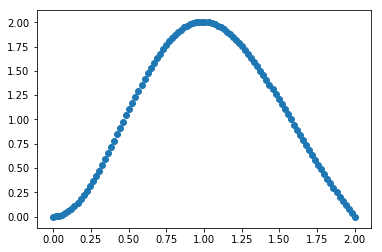

In [4]:
plt.scatter(lamb, y)

2. low band passes filter

In [5]:
x = np.linspace(0,2, 20)
y = 2.0 * np.array([1.0, 0.9, 0.85, 0.8, 0.75, 0.7, 0.6, 0.4, 0.3, 0.2, 0.1, 0.1, 0.05, 0.04, 0.03, 0.02, 0.01, 0.01, 0, 0])

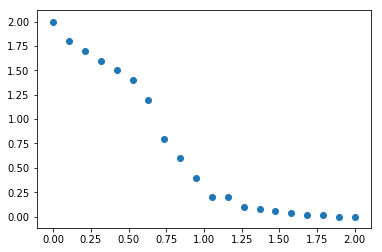

In [6]:
plt.scatter(x,y)
h = 0.5

In [7]:
A = np.array([[np.array([1.0 for i in range(20)])], [2.0*(h*x - 1j)/ (h*x + 1j)], [2.0*((h*x - 1j)**2)/ ((h*x + 1j)**2)], [2.0*((h*x - 1j)**3)/ ((h*x + 1j)**3)]])
A = A.real 

In [8]:
A = np.matrix(A)
y = np.matrix(y)

In [9]:
coefficients_low = np.linalg.inv(A.dot(A.T) + 0.1*np.eye(4, dtype = float)) * A * y.T
coefficients_low = np.array(coefficients_low)[:,0]

In [10]:
lamb = np.linspace(0,2,100)
c = coefficients_low
r = 3
y = cayley(lamb, c, h, r)

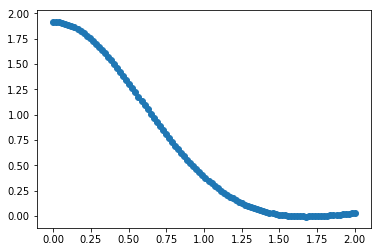

In [11]:
plt.scatter(lamb, y)

3. low band passes filter

In [12]:
x = np.linspace(0,2, 20)
y = 2.0 * np.array([1.0, 0.9, 0.85, 0.8, 0.75, 0.7, 0.6, 0.4, 0.3, 0.2, 0.1, 0.1, 0.05, 0.04, 0.03, 0.02, 0.01, 0.01, 0, 0])
y = np.flip(y, 0)
print(y)

[0.   0.   0.02 0.02 0.04 0.06 0.08 0.1  0.2  0.2  0.4  0.6  0.8  1.2
 1.4  1.5  1.6  1.7  1.8  2.  ]


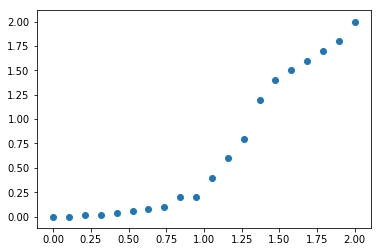

In [13]:
plt.scatter(x,y)

In [14]:
A = np.array([[np.array([1.0 for i in range(20)])], [2.0*(h*x - 1j)/ (h*x + 1j)], [2.0*((h*x - 1j)**2)/ ((h*x + 1j)**2)], [2.0*((h*x - 1j)**3)/ ((h*x + 1j)**3)]])
A = A.real 

In [15]:
A = np.matrix(A)
y = np.matrix(y)

In [16]:
coefficients_high = np.linalg.inv(A.dot(A.T) + 0.1*np.eye(4, dtype = float)) * A * y.T
coefficients_high = np.array(coefficients_high)[:,0]

In [17]:
lamb = np.linspace(0,2,100)
c = coefficients_high
r = 3
y = cayley(lamb, c, h, r)

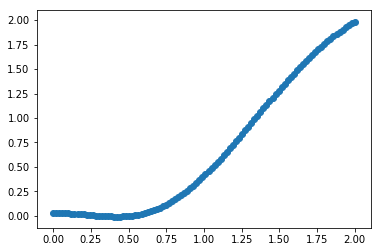

In [18]:
plt.scatter(lamb, y)

Summary

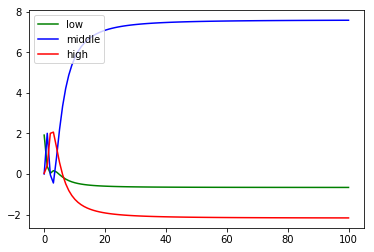

In [19]:
lamb = np.linspace(0,100, 100)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(lamb, cayley(lamb, coefficients_low, h, r), c='g', label='low')
ax1.plot(lamb, cayley(lamb, coefficients_middle, h, r), c='b', label='middle')
ax1.plot(lamb, cayley(lamb, coefficients_high, h, r),c='r', label='high')
plt.legend(loc='upper left');
plt.show()

In [52]:
print(coefficients_low)
print(coefficients_middle)
print(coefficients_high)

[ 0.32769867 -0.43970056  0.14869137 -0.20597721]
[1.9, 0.95, 0.95, 0.95]
[ 0.45555155 -0.18151883 -0.76448183 -0.37029683]


Experiment

In [20]:
##########################
###                    ###
###   PERTURBATION 1   ###
###                    ###
##########################


def remove_random_edges(A, k):
    """This function removes fraction k of graph edges."""
    
    if k<0:
        print("k must be positive.")
        return
    
    if k>1:
        print("k must be <=1.")
        return
    
    if k==0:
        A_tilde = sp.csr_matrix(A, dtype=np.float32)
        A_tilde.eliminate_zeros()
        print("k = ", k, " -> Removing 0 edges out of ", A_tilde.nnz // 2, ".")
        return A_tilde
    
    if k==1:
        M, M = A.shape
        A_tilde = np.zeros((M,M))
        A_tilde = sp.csr_matrix(A_tilde, dtype=np.float32)
        A_tilde.eliminate_zeros()
        print("k = ", k, " -> Removing all edges.")
        return A_tilde
    
    
    A_csr = sp.csr_matrix(A, dtype=np.float32)
    A_csr.setdiag(0)
    A_csr.eliminate_zeros()
    
    A_coo = sp.triu(A_csr, format='coo') 
    A_coo.eliminate_zeros()

    if k<1: 
        tot_edges = A_coo.nnz
        del_edges = int(round(k * tot_edges))
        
        zeros = np.zeros(del_edges)
        ones = np.ones(tot_edges - del_edges)
        mask = np.random.permutation(np.concatenate((zeros, ones), axis=0))
               
        print("k = ", k, " -> Removing ", del_edges, " edges out of ", tot_edges, ".")      
   
        A_coo.data = A_coo.data * mask

        A_coo.eliminate_zeros()
        
        A_output = A_coo + A_coo.transpose()

        A_output = A_output.tocsr() 
        A_output.setdiag(0)
        A_output.eliminate_zeros()    
           
        return A_output

In [21]:

# Generate random weight matrix NxN
A, _, _, _, _, _ = process_data.load_data("cora")
N, _ = A.shape
print("Matrix size = ", A.shape, " Number of edges = ", scipy.sparse.csr_matrix(A, dtype=np.float32).nnz // 2, "\n")


# Convert generated matrix into csr format
A_csr = scipy.sparse.csr_matrix(A, dtype=np.float32)

# Compute Laplacian of original matrix B
laplacian_A_csr = graph.laplacian(A_csr, normalized=True)

# Normalization factor
norm_factor = np.linalg.norm(laplacian_A_csr.toarray(), 'fro')
# Scale 
#h_1 = h * 2.0 / norm_factor
h_1 = h

(2708, 2708)
(2708, 1433)
Matrix size =  (2708, 2708)  Number of edges =  5278 



In [22]:
random_level = np.arange(0, 0.9, 0.01)
L_dif_1 = []
G_dif_1 = []
t_start = time.time()
for level in random_level:
    A_prime = remove_random_edges(A, level)
    L_prime = graph.laplacian(A_prime, normalized=True)
    L_dif_1.append(np.linalg.norm(laplacian_A_csr.toarray() - L_prime.toarray(), 'fro') / norm_factor)
    a = (h_1*laplacian_A_csr.toarray() - 1j*np.identity(N)) @ np.linalg.inv(h_1*laplacian_A_csr.toarray() + 1j*np.identity(N))
    b = (h_1*L_prime.toarray() - 1j*np.identity(N))@ np.linalg.inv(h_1*L_prime.toarray() + 1j*np.identity(N))
    low_a = 2.0*coefficients_low[1]*(a.real) + 2.0*coefficients_low[2]*((a@a).real) + 2.0*coefficients_low[3]*((a@a@a).real)
    middle_a = 2.0*coefficients_middle[1]*(a.real) + 2.0*coefficients_middle[2]*((a@a).real) + 2.0*coefficients_middle[3]*((a@a@a).real)
    high_a = 2.0*coefficients_high[1]*(a.real) + 2.0*coefficients_high[2]*((a@a).real) + 2.0*coefficients_high[3]*((a@a@a).real)
    low_b = 2.0*coefficients_low[1]*(b.real) + 2.0*coefficients_low[2]*((b@b).real) + 2.0*coefficients_low[3]*((b@b@b).real)
    middle_b = 2.0*coefficients_middle[1]*(b.real) + 2.0*coefficients_middle[2]*((b@b).real) + 2.0*coefficients_middle[3]*((b@b@b).real)
    high_b = 2.0*coefficients_high[1]*(b.real) + 2.0*coefficients_high[2]*((b@b).real) + 2.0*coefficients_high[3]*((b@b@b).real)
    G_dif_1.append([np.linalg.norm(low_a-low_b,'fro')/norm_factor, np.linalg.norm(middle_a-middle_b,'fro')/norm_factor, np.linalg.norm(high_a-high_b,'fro')/norm_factor])  
G_dif_1 = np.array(G_dif_1)    
print('Execution time: {:.2f}s'.format(time.time() - t_start))

k =  0.0  -> Removing 0 edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.01  -> Removing  53  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.02  -> Removing  106  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.03  -> Removing  158  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.04  -> Removing  211  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.05  -> Removing  264  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.06  -> Removing  317  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.07  -> Removing  369  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.08  -> Removing  422  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.09  -> Removing  475  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.1  -> Removing  528  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.11  -> Removing  581  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.12  -> Removing  633  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.13  -> Removing  686  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.14  -> Removing  739  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.15  -> Removing  792  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.16  -> Removing  844  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.17  -> Removing  897  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.18  -> Removing  950  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.19  -> Removing  1003  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.2  -> Removing  1056  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.21  -> Removing  1108  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.22  -> Removing  1161  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.23  -> Removing  1214  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.24  -> Removing  1267  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.25  -> Removing  1320  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.26  -> Removing  1372  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.27  -> Removing  1425  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.28  -> Removing  1478  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.29  -> Removing  1531  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.3  -> Removing  1583  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.31  -> Removing  1636  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.32  -> Removing  1689  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.33  -> Removing  1742  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.34  -> Removing  1795  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.35000000000000003  -> Removing  1847  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.36  -> Removing  1900  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.37  -> Removing  1953  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.38  -> Removing  2006  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.39  -> Removing  2058  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.4  -> Removing  2111  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.41000000000000003  -> Removing  2164  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.42  -> Removing  2217  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.43  -> Removing  2270  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.44  -> Removing  2322  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.45  -> Removing  2375  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.46  -> Removing  2428  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.47000000000000003  -> Removing  2481  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.48  -> Removing  2533  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.49  -> Removing  2586  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.5  -> Removing  2639  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.51  -> Removing  2692  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.52  -> Removing  2745  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.53  -> Removing  2797  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.54  -> Removing  2850  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.55  -> Removing  2903  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.56  -> Removing  2956  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.5700000000000001  -> Removing  3008  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.58  -> Removing  3061  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.59  -> Removing  3114  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.6  -> Removing  3167  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.61  -> Removing  3220  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.62  -> Removing  3272  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.63  -> Removing  3325  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.64  -> Removing  3378  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.65  -> Removing  3431  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.66  -> Removing  3483  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.67  -> Removing  3536  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.68  -> Removing  3589  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.6900000000000001  -> Removing  3642  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.7000000000000001  -> Removing  3695  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.71  -> Removing  3747  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.72  -> Removing  3800  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.73  -> Removing  3853  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.74  -> Removing  3906  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.75  -> Removing  3958  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.76  -> Removing  4011  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.77  -> Removing  4064  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.78  -> Removing  4117  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.79  -> Removing  4170  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.8  -> Removing  4222  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.81  -> Removing  4275  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.8200000000000001  -> Removing  4328  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.8300000000000001  -> Removing  4381  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.84  -> Removing  4434  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.85  -> Removing  4486  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.86  -> Removing  4539  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.87  -> Removing  4592  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.88  -> Removing  4645  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.89  -> Removing  4697  edges out of  5278 .
Execution time: 1719.58s


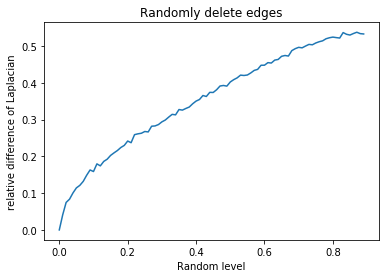

In [23]:
plt.plot(random_level, L_dif_1)
plt.ylabel('relative difference of Laplacian')
plt.xlabel('Random level')
plt.title('Randomly delete edges')
plt.show()

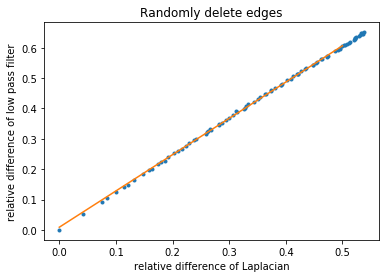

In [34]:
xp = np.linspace(0, 0.5, 100)
p1 = np.poly1d(np.polyfit(L_dif_1, G_dif_1[:,0], 1))
plt.plot(L_dif_1, G_dif_1[:,0], '.', xp, p1(xp), '-')
plt.ylabel('relative difference of low pass filter')
plt.xlabel('relative difference of Laplacian')
plt.title('Randomly delete edges')
plt.show()

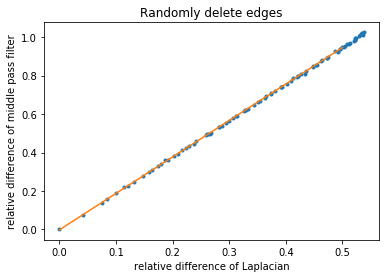

In [35]:
xp = np.linspace(0, 0.5, 100)
p1 = np.poly1d(np.polyfit(L_dif_1, G_dif_1[:,1], 1))
plt.plot(L_dif_1, G_dif_1[:,1], '.', xp, p1(xp), '-')
plt.ylabel('relative difference of middle pass filter')
plt.xlabel('relative difference of Laplacian')
plt.title('Randomly delete edges')
plt.show()

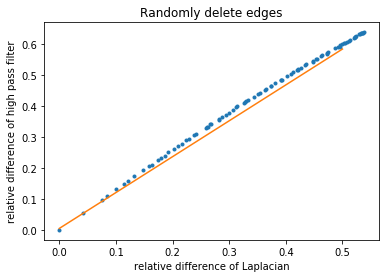

In [46]:
xp = np.linspace(0, 0.5, 100)
p1 = np.poly1d(np.polyfit(L_dif_1, G_dif_1[:,2], 1))
plt.plot(L_dif_1, G_dif_1[:,2], '.', xp, p1(xp)-0.02, '-')
plt.ylabel('relative difference of high pass filter')
plt.xlabel('relative difference of Laplacian')
plt.title('Randomly delete edges')
plt.show()

In [43]:
##########################
###                    ###
###   PERTURBATION 2   ###
###                    ###
##########################


def add_random_edges(A, k):
    """This function adds fraction k of graph edges."""
    
    if k<0:
        print("k must be positive.")
        return
    
    if k>1:
        print("k must be <=1.")
        return
    
    if k==0:
        A_tilde = sp.csr_matrix(A, dtype=np.float32)
        A_tilde.eliminate_zeros()
        print("k = ", k, " -> Adding 0 edges out of ", A_tilde.nnz // 2, ".")
        return A_tilde
    
    if k==1:
        M, M = A.shape
        A_tilde = np.ones((M,M))
        A_tilde = sp.csr_matrix(A_tilde, dtype=np.float32)
        A_tilde.eliminate_zeros()
        print("k = ", k, " -> Adding all missing edges.")
        return A_tilde
    
    
    A_csr = sp.csr_matrix(A, dtype=np.float32)
    A_csr.setdiag(0)
    A_csr.eliminate_zeros()
    
    A_coo = sp.triu(A_csr, format='coo') 
    A_coo.eliminate_zeros()
    
    
    if k<1:
        M, M = A.shape

        mask = np.triu(np.ones((M,M)), k=1) # k=1 means that non-zeros are only above main diagonal
        mask_coo = sp.coo_matrix(mask)     
        mask_coo = mask_coo - A_coo    
        mask_coo.eliminate_zeros()
        #print(mask_coo) #.toarray().astype(int)
        
        missing_edges = mask_coo.nnz
        add_edges = int(round(k * 5278))
        
        print("k = ", k, " -> Adding ", add_edges, " edges out of ", missing_edges, " missing.")
         
        zeros = np.zeros(add_edges)
        ones = np.ones(missing_edges - add_edges)
        filter_mask = np.random.permutation(np.concatenate((zeros, ones), axis=0))
        
        mask_coo.data = mask_coo.data - filter_mask
        mask_coo.eliminate_zeros()
        
        A_augmented_coo = A_coo + mask_coo
        
        A_output = A_augmented_coo + A_augmented_coo.transpose()
        
        #print(A_output.toarray().astype(int))     
   
        A_output = A_output.tocsr() 
        A_output.setdiag(0)
        A_output.eliminate_zeros()    
           
        return A_output

In [44]:
# Generate random weight matrix NxN

# Generate random weight matrix NxN
A, _, _, _, _, _ = process_data.load_data("cora")
N, _ = A.shape
print("Matrix size = ", A.shape, " Number of edges = ", scipy.sparse.csr_matrix(A, dtype=np.float32).nnz // 2, "\n")


# Convert generated matrix into csr format
A_csr = scipy.sparse.csr_matrix(A, dtype=np.float32)

# Compute Laplacian of original matrix B
laplacian_A_csr = graph.laplacian(A_csr, normalized=True)

# Normalization factor
norm_factor = np.linalg.norm(laplacian_A_csr.toarray(), 'fro')
# Scale 
#h_1 = h * 2.0 / norm_factor
h_2 = h

(2708, 2708)
(2708, 1433)
Matrix size =  (2708, 2708)  Number of edges =  5278 



In [45]:
random_level = np.arange(0, 0.9, 0.01)
L_dif_2 = []
G_dif_2 = []
t_start = time.time()
for level in random_level:
    A_prime = add_random_edges(A, level)
    L_prime = graph.laplacian(A_prime, normalized=True)
    L_dif_2.append(np.linalg.norm(laplacian_A_csr.toarray() - L_prime.toarray(), 'fro') / norm_factor)
    a = (h_2*laplacian_A_csr.toarray() - 1j*np.identity(N)) @ np.linalg.inv(h_2*laplacian_A_csr.toarray() + 1j*np.identity(N))
    b = (h_2*L_prime.toarray() - 1j*np.identity(N))@ np.linalg.inv(h_2*L_prime.toarray() + 1j*np.identity(N))
    low_a = 2.0*coefficients_low[1]*(a.real) + 2.0*coefficients_low[2]*((a@a).real) + 2.0*coefficients_low[3]*((a@a@a).real)
    middle_a = 2.0*coefficients_middle[1]*(a.real) + 2.0*coefficients_middle[2]*((a@a).real) + 2.0*coefficients_middle[3]*((a@a@a).real)
    high_a = 2.0*coefficients_high[1]*(a.real) + 2.0*coefficients_high[2]*((a@a).real) + 2.0*coefficients_high[3]*((a@a@a).real)
    low_b = 2.0*coefficients_low[1]*(b.real) + 2.0*coefficients_low[2]*((b@b).real) + 2.0*coefficients_low[3]*((b@b@b).real)
    middle_b = 2.0*coefficients_middle[1]*(b.real) + 2.0*coefficients_middle[2]*((b@b).real) + 2.0*coefficients_middle[3]*((b@b@b).real)
    high_b = 2.0*coefficients_high[1]*(b.real) + 2.0*coefficients_high[2]*((b@b).real) + 2.0*coefficients_high[3]*((b@b@b).real)
    G_dif_2.append([np.linalg.norm(low_a-low_b,'fro')/norm_factor, np.linalg.norm(middle_a-middle_b,'fro')/norm_factor, np.linalg.norm(high_a-high_b,'fro')/norm_factor])  
G_dif_2 = np.array(G_dif_2)    
print('Execution time: {:.2f}s'.format(time.time() - t_start))

k =  0.0  -> Adding 0 edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.01  -> Adding  53  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.02  -> Adding  106  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.03  -> Adding  158  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.04  -> Adding  211  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.05  -> Adding  264  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.06  -> Adding  317  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.07  -> Adding  369  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.08  -> Adding  422  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.09  -> Adding  475  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.1  -> Adding  528  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.11  -> Adding  581  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.12  -> Adding  633  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.13  -> Adding  686  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.14  -> Adding  739  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.15  -> Adding  792  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.16  -> Adding  844  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.17  -> Adding  897  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.18  -> Adding  950  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.19  -> Adding  1003  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.2  -> Adding  1056  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.21  -> Adding  1108  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.22  -> Adding  1161  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.23  -> Adding  1214  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.24  -> Adding  1267  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.25  -> Adding  1320  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.26  -> Adding  1372  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.27  -> Adding  1425  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.28  -> Adding  1478  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.29  -> Adding  1531  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.3  -> Adding  1583  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.31  -> Adding  1636  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.32  -> Adding  1689  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.33  -> Adding  1742  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.34  -> Adding  1795  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.35000000000000003  -> Adding  1847  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.36  -> Adding  1900  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.37  -> Adding  1953  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.38  -> Adding  2006  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.39  -> Adding  2058  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.4  -> Adding  2111  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.41000000000000003  -> Adding  2164  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.42  -> Adding  2217  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.43  -> Adding  2270  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.44  -> Adding  2322  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.45  -> Adding  2375  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.46  -> Adding  2428  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.47000000000000003  -> Adding  2481  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.48  -> Adding  2533  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.49  -> Adding  2586  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.5  -> Adding  2639  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.51  -> Adding  2692  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.52  -> Adding  2745  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.53  -> Adding  2797  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.54  -> Adding  2850  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.55  -> Adding  2903  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.56  -> Adding  2956  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.5700000000000001  -> Adding  3008  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.58  -> Adding  3061  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.59  -> Adding  3114  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.6  -> Adding  3167  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.61  -> Adding  3220  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.62  -> Adding  3272  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.63  -> Adding  3325  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.64  -> Adding  3378  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.65  -> Adding  3431  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.66  -> Adding  3483  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.67  -> Adding  3536  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.68  -> Adding  3589  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.6900000000000001  -> Adding  3642  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.7000000000000001  -> Adding  3695  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.71  -> Adding  3747  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.72  -> Adding  3800  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.73  -> Adding  3853  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.74  -> Adding  3906  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.75  -> Adding  3958  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.76  -> Adding  4011  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.77  -> Adding  4064  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.78  -> Adding  4117  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.79  -> Adding  4170  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.8  -> Adding  4222  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.81  -> Adding  4275  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.8200000000000001  -> Adding  4328  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.8300000000000001  -> Adding  4381  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.84  -> Adding  4434  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.85  -> Adding  4486  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.86  -> Adding  4539  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.87  -> Adding  4592  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.88  -> Adding  4645  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.89  -> Adding  4697  edges out of  3660000  missing.
Execution time: 1822.32s


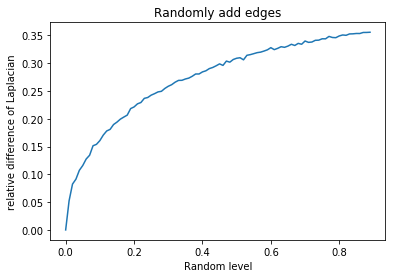

In [47]:
plt.plot(random_level, L_dif_2)
plt.ylabel('relative difference of Laplacian')
plt.xlabel('Random level')
plt.title('Randomly add edges')
plt.show()

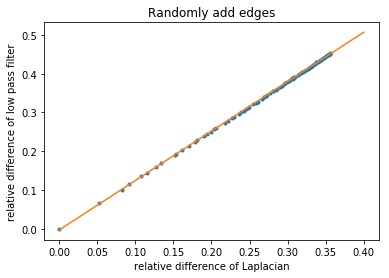

In [49]:
xp = np.linspace(0, .4, 100)
p1 = np.poly1d(np.polyfit(L_dif_2, G_dif_2[:,0], 1))
plt.plot(L_dif_2, G_dif_2[:,0], '.', xp, p1(xp), '-')
plt.ylabel('relative difference of low pass filter')
plt.xlabel('relative difference of Laplacian')
plt.title('Randomly add edges')
plt.show()

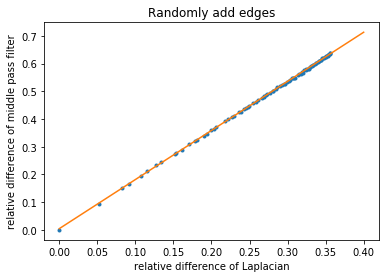

In [50]:
xp = np.linspace(0, .4, 100)
p1 = np.poly1d(np.polyfit(L_dif_2, G_dif_2[:,1], 1))
plt.plot(L_dif_2, G_dif_2[:,1], '.', xp, p1(xp), '-')
plt.ylabel('relative difference of middle pass filter')
plt.xlabel('relative difference of Laplacian')
plt.title('Randomly add edges')
plt.show()

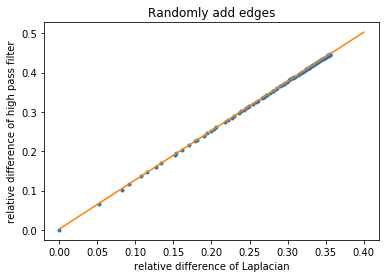

In [51]:
xp = np.linspace(0, .4, 100)
p1 = np.poly1d(np.polyfit(L_dif_2, G_dif_2[:,2], 1))
plt.plot(L_dif_2, G_dif_2[:,2], '.', xp, p1(xp), '-')
plt.ylabel('relative difference of high pass filter')
plt.xlabel('relative difference of Laplacian')
plt.title('Randomly add edges')
plt.show()